# 311 Data Exploratory Data Analysis


## References:
Neighborhoods Geojson: https://data.sfgov.org/Geographic-Locations-and-Boundaries/SF-Find-Neighborhoods/pty2-tcw4

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from PIL import Image

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, roc_curve

# Metrics
from sklearn.metrics import confusion_matrix

% matplotlib inline

In [3]:
# Using the first 60000 data points
# Limited due to computational time and disc space
files = glob.glob('bw_pickles/bw_[0-9]*.gzde')
# For repeatability
files = sorted(files)
print(len(files))

df = pd.concat([pd.read_pickle(fp, compression='gzip') for fp in files])
# Some files have same index, need to reindex
df.reset_index(inplace=True, drop=True)

columns = list(df.columns)
columns = [column.lower().replace(' ', '_') for column in columns]
df.columns = columns
# Drop columns without an image - won't be using for analysis on images
df.dropna(subset=['image'], inplace=True)
# Drop image column for space
df.drop(columns=['image'], inplace=True)

df['updated'] = pd.to_datetime(df['updated'])
df['opened'] = pd.to_datetime(df['opened'])
df['closed'] = pd.to_datetime(df['closed'])
df['month'] = df['month'].astype('int16')
df['year'] = df['year'].astype('int16')
df['caseid'] = df['caseid'].astype('int')
df['neighborhood'] = df['neighborhood'].astype('category')
df['police_district'] = df['police_district'].astype('category')
df['street'] = df['street'].astype('category')
df['category'] = df['category'].astype('category')
df['status'] = df['status'].astype('category')
df['responsible_agency'] = df['responsible_agency'].astype('category')
df['neighborhood'] = df['neighborhood'].astype('str')
df['street'] = df['street'].astype('str')

166


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164509 entries, 0 to 165515
Data columns (total 22 columns):
caseid                 164509 non-null int64
opened                 164509 non-null datetime64[ns]
closed                 161314 non-null datetime64[ns]
updated                164509 non-null datetime64[ns]
status                 164509 non-null category
status_notes           106796 non-null object
responsible_agency     164509 non-null category
category               164509 non-null category
request_type           164509 non-null object
request_details        161514 non-null object
address                164509 non-null object
street                 164509 non-null object
supervisor_district    164499 non-null float64
neighborhood           164509 non-null object
police_district        164137 non-null category
latitude               164509 non-null float64
longitude              164509 non-null float64
point                  164509 non-null object
source                 1645

In [63]:
df['day'] = df['opened'].dt.dayofweek

In [14]:
df['source'].unique()

array(['Mobile/Open311', 'Web', 'Phone', 'Twitter', 'Other Department'],
      dtype=object)

In [15]:
# Can't convert supervisor district to ints because of nan values
df.supervisor_district.unique()

array([ 6.,  8.,  4.,  9.,  5., 10.,  3., 11.,  2.,  1.,  7.,  0., nan])

# Which feature to use as a label?
The categories feature is dominated by a couple of labels.  There are too many different kinds of request types.  As a solution, I combined some of the smaller categories into unified categories, and split some of the larger categories into request types.  Categories with very few examples are grouped into "Other."

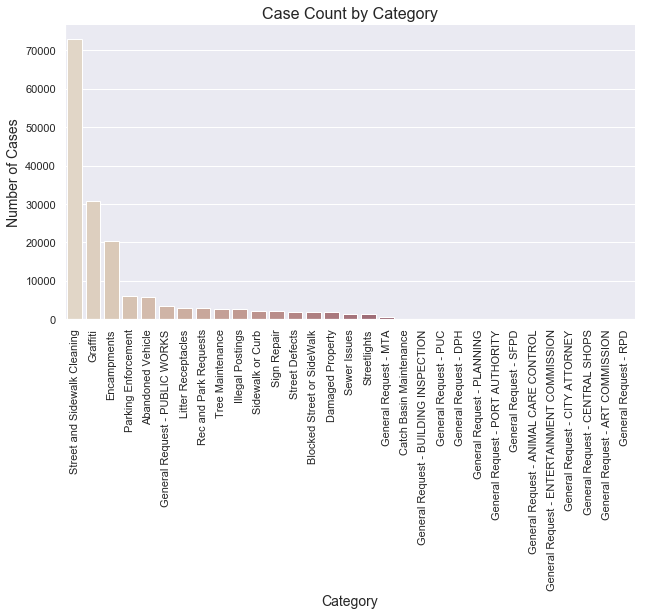

Number of categories: 31


In [93]:
sns.catplot(x='category', 
            kind='count', 
            palette="ch:.25", 
            height=5, 
            aspect=2,
            order = df['category'].value_counts().index,
            data=df)
sns.set(rc={'figure.figsize':(10,20)})
plt.xticks(rotation=90)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.title('Case Count by Category', fontsize=16)
plt.show()
print('Number of categories: {}'.format(df['category'].nunique()))

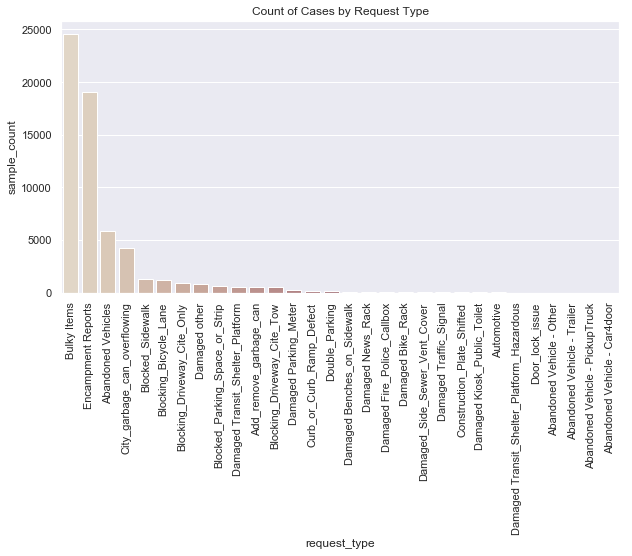

Number of Request Types: 119


In [98]:
request_types = df.groupby('request_type').count()['caseid'][0:30]
request_types = request_types.sort_values(ascending=False).reset_index()
request_types.columns = ['request_type', 'sample_count']

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='request_type', 
            y='sample_count', 
            palette="ch:.25",
            ax=ax,
            data=request_types)
plt.xticks(rotation=90)
plt.title('Count of Cases by Request Type')
plt.show()

print('Number of Request Types: {}'.format(df['request_type'].nunique()))

In [16]:
def categorize(df):
    if df['category'] == 'Street and Sidewalk Cleaning':
        if (df['request_type'] == 'Transit_shelter_platform' or
            df['request_type'] == 'Missed_Route_Mechanical_Sweeping'):
            return 'General Cleaning'
        elif df['request_type'] == 'City_garbage_can_overflowing':
            return 'Litter Receptacles'
        elif (df['request_type'] == 'Human Waste' or
              df['request_type'] == 'Medical Waste'):
            return 'Human or Medical Waste'
        elif df['request_type'] == 'Automotive':
            return 'Vehicle'
        else:
            return df['request_type']
    elif ('General' in df['category']) or ('Catch Basin' in df['category']):
        return 'Other'
    elif ((df['category'] == 'Street Defects') or 
          (df['category'] == 'Sidewalk or Curb') or 
          (df['category'] == 'Blocked Street or SideWalk')):
        return 'Street and Sidewalk Issues'
    elif ((df['category'] == 'Abandoned Vehicle') or 
          (df['category'] == 'Parking Enforcement')):
        return 'Vehicle'
    elif (df['category'] == 'Illegal Postings' or
          df['category'] == 'Sign Repair'):
        return 'Signs - Illegal Postings and Repair'
    else:
        return df['category']

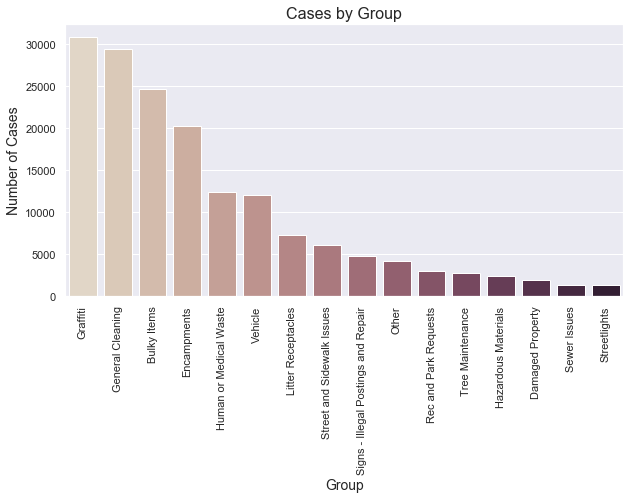

In [99]:
requested = df.groupby('group').count()['caseid'].sort_values(ascending=False).reset_index()
requested.columns = ['group', 'sample_count']

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x='group', 
            y='sample_count', 
            palette="ch:.25",
            ax=ax,
            data=requested)
plt.xticks(rotation=90)
plt.title('Cases by Group', fontsize=16)
plt.xlabel('Group', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.show()

In [17]:
df['group'] = df.apply(categorize, axis=1)
print(df['group'].unique())
print(df['group'].nunique())

['Graffiti' 'Vehicle' 'General Cleaning' 'Litter Receptacles'
 'Hazardous Materials' 'Street and Sidewalk Issues'
 'Rec and Park Requests' 'Bulky Items' 'Encampments'
 'Human or Medical Waste' 'Other' 'Signs - Illegal Postings and Repair'
 'Tree Maintenance' 'Sewer Issues' 'Streetlights' 'Damaged Property']
16


In [18]:
df.head()

,caseid,opened,closed,updated,status,status_notes,responsible_agency,category,request_type,request_details,...,neighborhood,police_district,latitude,longitude,point,source,media_url,year,month,group
0,7228536,2017-06-06 07:31:38,2017-06-10 12:26:23,2017-06-10 12:26:23,Closed,SES Graffiti Crew - Paint - Box - Sub Panel -...,DPW Ops Queue,Graffiti,Graffiti on Signal_box,Signal_box - Not_Offensive,...,South of Market,SOUTHERN,37.774734,-122.400620,"(37.7747345, -122.40061951)",Mobile/Open311,http://mobile311.sfgov.org/reports/7228536/photos,2017,6,Graffiti
1,9848318,2018-11-25 13:15:00,2018-11-25 14:04:15,2018-11-25 14:04:15,Closed,Officer responded to request under CAD # 18329...,Parking Enforcement Dispatch Queue,Parking Enforcement,Other_Illegal_Parking,Silver - Civic - 5xcs051,...,Tenderloin,TENDERLOIN,37.783645,-122.410763,"(37.78364452, -122.41076323)",Mobile/Open311,http://mobile311.sfgov.org/reports/9848318/photos,2018,11,Vehicle
2,9849482,2018-11-25 19:32:40,2019-02-27 21:30:07,2019-02-27 21:30:07,Closed,Per process - cases are closed 10 days after a...,Clear Channel - Transit Queue,Street and Sidewalk Cleaning,Transit_shelter_platform,Transit_shelter_platform,...,Rincon Hill,SOUTHERN,37.785531,-122.396656,"(37.7855311, -122.3966557)",Mobile/Open311,http://mobile311.sfgov.org/reports/9849482/photos,2018,11,General Cleaning
3,9681555,2018-10-16 17:25:00,2018-10-20 16:24:00,2018-10-20 16:24:00,Closed,NaN,DPW Ops Queue,Graffiti,Graffiti on Sidewalk_in_front_of_property,Sidewalk_in_front_of_property - Not_Offensive,...,Duboce Triangle,PARK,37.766496,-122.431225,"(37.76649554, -122.43122539)",Mobile/Open311,http://mobile311.sfgov.org/reports/9681555/photos,2018,10,Graffiti
4,9253531,2018-07-11 14:21:09,2018-07-12 18:33:00,2018-07-12 18:33:00,Closed,NaN,DPW Ops Queue,Litter Receptacles,Other_garbage_can_repair,NaN,...,Outer Sunset,TARAVAL,37.763896,-122.509486,"(37.76389604, -122.50948554)",Mobile/Open311,http://mobile311.sfgov.org/reports/9253531/photos,2018,7,Litter Receptacles


In [19]:
df.caseid.nunique()

164509

In [20]:
# Quick check for duplicate case id's
df.groupby('caseid')['status'].count().sort_values(ascending=False)[0:5]

caseid
10300761    1
8136040     1
8137408     1
8137405     1
8137392     1
Name: status, dtype: int64

In [21]:
df.status_notes.unique()

array(['SES Graffiti Crew  - Paint - Box - Sub Panel - High Voltage',
       'Officer responded to request under CAD # 183291647. Unable to Locate.',
       'Per process - cases are closed 10 days after assignment.', ...,
       'SES Graffiti Crew  - Paint - Pole - Shared (Comment)\nSES Graffiti Crew  - Paint - Pole - MUNI',
       '09/25/2017 DUPLICATE CASE#8055603',
       'nothing found at the location'], dtype=object)

## Looking at When Cases Occurred

In [22]:
# Checking date range, should all be in 2017 and 2018
print(df.opened.min())
print(df.opened.max())

2017-01-01 00:28:33
2018-12-31 22:14:00


In [23]:
# Checking date range, should not be before 2017
print(df.updated.min())
print(df.updated.max())

2017-01-01 10:54:58
2019-04-06 08:00:44


In [24]:
groups = df.set_index('opened').groupby('group')['caseid'].resample('Y').count().unstack()

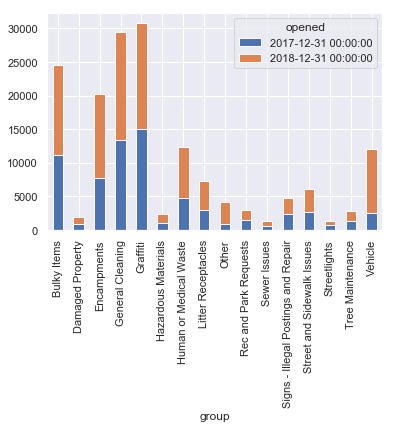

In [25]:
# Checking 2017 and 2018 proportions, vehicle increased 2018
sns.set()
groups.plot(kind='bar', stacked=True)
plt.show()

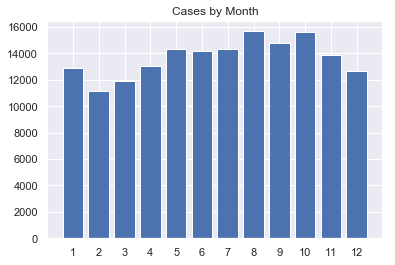

In [26]:
# Looking at the monthly distribution of reports
groups_month = df.groupby('month')['caseid'].count()
plt.title('Cases by Month')
plt.bar(x=range(1,13), height=groups_month)
plt.xticks(range(1,13))
plt.show()

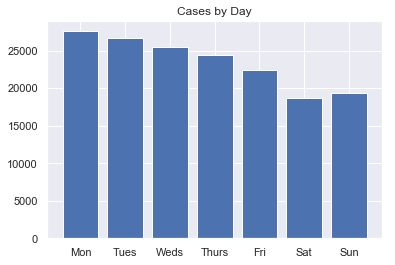

In [68]:
# Looking at the daily distribution of reports
groups_day = df.groupby('day')['caseid'].count()
plt.title('Cases by Day')
plt.bar(x=range(0,7), height=groups_day)
plt.xticks(range(0, 7), ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.show()

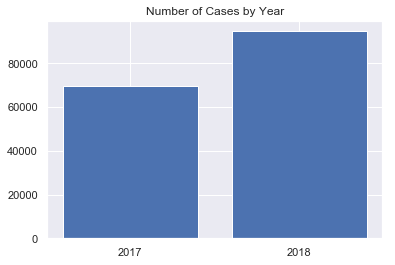

In [27]:
# Look at the yearly breakdown of reports
# More reports 
groups_year = df.groupby('year')['caseid'].count()
plt.title('Number of Cases by Year')
plt.bar(x=range(2017, 2019), height=groups_year)
plt.xticks([2017, 2018])
plt.show()

## Cases by Source

source
Mobile/Open311      155354
Other Department         3
Phone                  370
Twitter                 29
Web                   8753
Name: caseid, dtype: int64


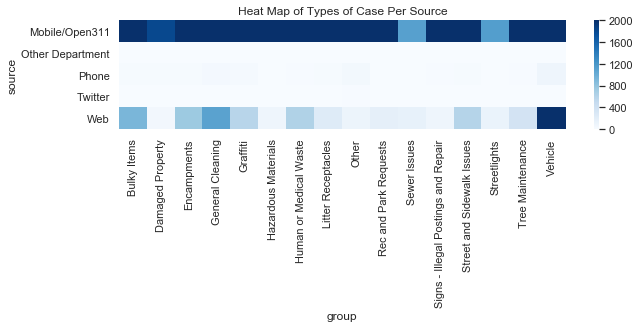

In [29]:
# Look at the most common streets and types of complaints
print(df.groupby('source')['caseid'].count())
source = df.groupby(['source', 'group'])['caseid'].count()
source = pd.DataFrame(source).reset_index()
source = source.pivot(index='source', columns='group', values='caseid')
source.fillna(0, inplace=True)

plt.figure(figsize=(10, 2))
sns.heatmap(source, vmin=0, vmax=2000, cmap='Blues')
plt.title('Heat Map of Types of Case Per Source')
plt.show()

The vast majority of cases are by mobile app.  This is likely not to add much to a model.

## Look into streets and nieghborhoods with a lot of requests

Unique Neighborhoods: 118
               neighborhood  count
0                   Mission  23956
1           South of Market  17616
2              Potrero Hill   7174
3           Mission Dolores   5057
4                 Chinatown   4201
5                   Bayview   4011
6              Outer Sunset   3900
7                Tenderloin   3594
8              Civic Center   3553
9   Downtown / Union Square   3179
10                Excelsior   3014
11           Lower Nob Hill   2857
12          Duboce Triangle   2772
13                 Nob Hill   2668
14           Bernal Heights   2585
15       Financial District   2516
16              North Beach   2427
17                   Castro   2371
18           Outer Richmond   2298
19             Lower Haight   2269


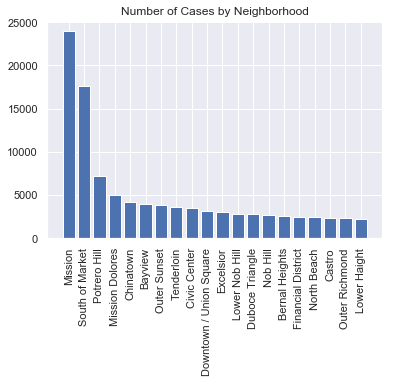

In [30]:
print('Unique Neighborhoods: {}'.format(df['neighborhood'].nunique()))
neighborhoods = df.groupby('neighborhood')['caseid'].count()
neighborhoods = neighborhoods.sort_values(ascending=False)
neighborhoods = pd.DataFrame(neighborhoods).reset_index()
neighborhoods.columns = ['neighborhood', 'count']
print(neighborhoods[0:20])
common_neighborhoods = neighborhoods.iloc[0:20]['neighborhood']

# Plot the neighborhood cases distribution
plt.title('Number of Cases by Neighborhood')
plt.bar(common_neighborhoods, height=neighborhoods['count'][0:20])
plt.xticks(rotation=90)
plt.show()

A couple of neighborhoods dominate the number of cases.

Unique Streets: 2043
                street  count
0           MISSION ST   5056
1            MARKET ST   4439
2              16TH ST   2522
3            FOLSOM ST   2465
4              18TH ST   2384
5              17TH ST   2221
6              24TH ST   1927
7               3RD ST   1592
8              19TH ST   1561
9        SAN BRUNO AVE   1476
10  SOUTH VAN NESS AVE   1379
11         HARRISON ST   1358
12           BRYANT ST   1358
13             15TH ST   1335
14         POTRERO AVE   1299
15         VALENCIA ST   1273
16             25TH ST   1251
17                 nan   1227
18           GRANT AVE   1112
19           HOWARD ST   1086


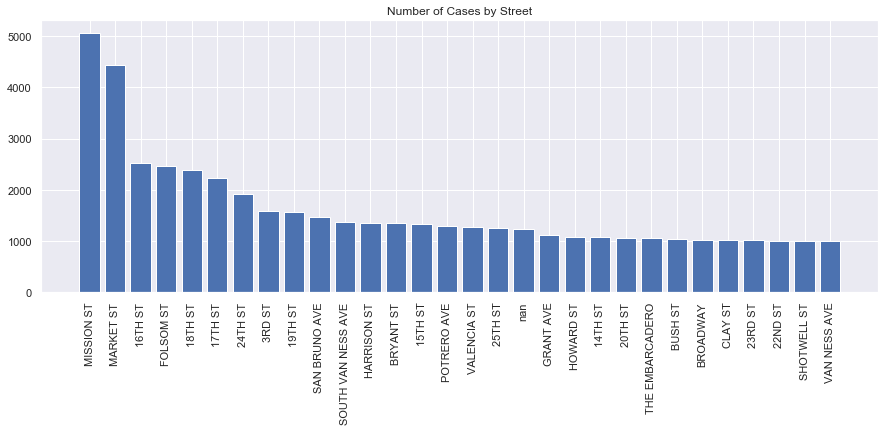

In [39]:
print('Unique Streets: {}'.format(df['street'].nunique()))
streets = df.groupby('street')['caseid'].count()
streets = streets.sort_values(ascending=False)
streets = pd.DataFrame(streets).reset_index()
streets.columns = ['street', 'count']
print(streets[0:20])
common_streets = streets.iloc[0:10]['street']

plt.figure(figsize=(15, 5))
plt.bar(streets['street'][0:30], streets['count'][0:30])
plt.xticks(rotation=90)
plt.title('Number of Cases by Street')
plt.show()

There are a lot more streets, but not quite as dominated by one street.

Unique Groups: 16
                                  group  count
0                              Graffiti  30820
1                      General Cleaning  29454
2                           Bulky Items  24593
3                           Encampments  20291
4                Human or Medical Waste  12346
5                               Vehicle  12021
6                    Litter Receptacles   7272
7            Street and Sidewalk Issues   6134
8   Signs - Illegal Postings and Repair   4803
9                                 Other   4232
10                Rec and Park Requests   2957
11                     Tree Maintenance   2791
12                  Hazardous Materials   2336
13                     Damaged Property   1898
14                         Sewer Issues   1287
15                         Streetlights   1274


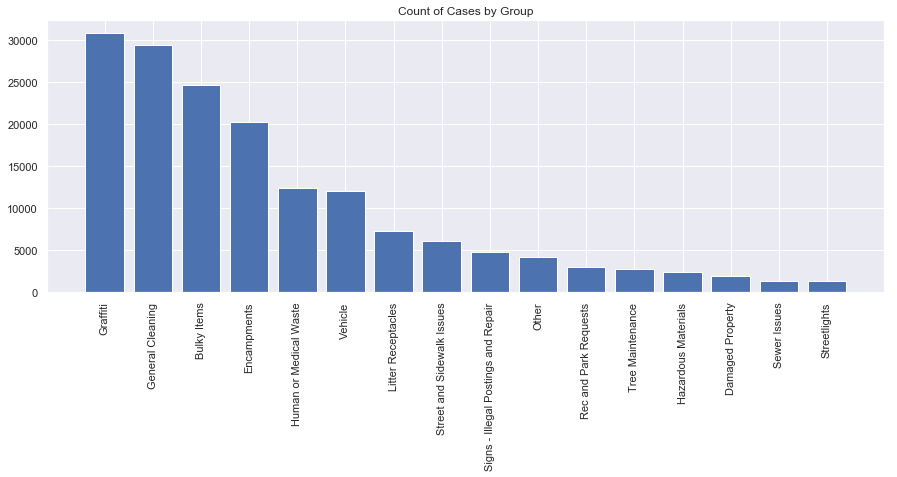

In [40]:
print('Unique Groups: {}'.format(df['group'].nunique()))
groups = df.groupby('group')['caseid'].count()
groups = groups.sort_values(ascending=False)
groups = pd.DataFrame(groups).reset_index()
groups.columns = ['group', 'count']
print(groups)
common_groups = groups.iloc[0:8]['group']

plt.figure(figsize=(15, 5))
plt.bar(groups['group'], groups['count'])
plt.title('Count of Cases by Group')
plt.xticks(rotation=90)
plt.show()

May need to combine some of the smaller groups into the Other category

## Type of Case by Street

In [41]:
# Look at the most common streets and types of complaints
street_type = df.groupby(['street', 'group'])['caseid'].count()
street_type = pd.DataFrame(street_type).reset_index()
street_type = street_type.loc[street_type['street'].isin(common_streets) == True]
street_type = street_type.loc[street_type['group'].isin(common_groups) == True]

In [42]:
street_type = street_type.pivot(index='street', 
                                columns='group', 
                                values='caseid')


In [43]:
street_type.fillna(0, inplace=True)
street_type.head()

group,Bulky Items,Encampments,General Cleaning,Graffiti,Human or Medical Waste,Litter Receptacles,Street and Sidewalk Issues,Vehicle
street,,,,,,,,
16TH ST,176,666,430,607,215,111,37,46
17TH ST,271,410,428,444,203,50,42,108
18TH ST,171,460,302,783,247,65,42,52
19TH ST,106,262,196,571,133,58,40,42
24TH ST,219,52,237,784,44,93,121,95


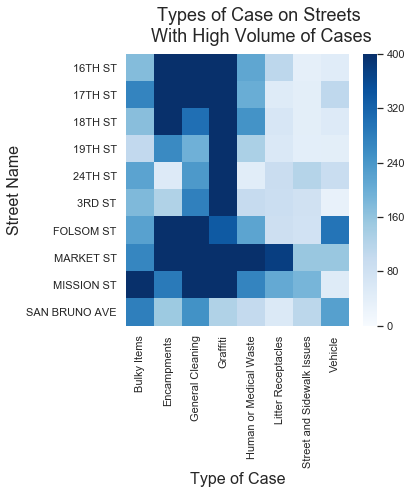

In [62]:
plt.figure(figsize=(5, 5))
sns.heatmap(street_type, vmin=0, vmax=400, cmap='Blues')
fig_title = 'Types of Case on Streets \nWith High Volume of Cases'
plt.suptitle(fig_title, fontsize=18, y=1.01)
plt.xlabel('Type of Case', fontsize=16)
plt.ylabel('Street Name', fontsize=16)
plt.savefig('StreetsAndCasesHeatmap.png', bbox_inches='tight')
plt.show()


## Type of Case by Neighborhood

In [26]:
neigh_type = df.groupby(['neighborhood', 'group'])['caseid'].count()
neigh_type = pd.DataFrame(neigh_type).reset_index()
neigh_type = neigh_type.loc[neigh_type['neighborhood'].isin(common_neighborhoods) == True]
neigh_type = neigh_type.loc[neigh_type['group'].isin(common_groups) == True]
neigh_type = neigh_type.pivot(index='neighborhood', columns='group', values='caseid')
neigh_type.fillna(0, inplace=True)
neigh_type.head()

group,Bulky Items,Encampments,General Cleaning,Graffiti,Human or Medical Waste,Litter Receptacles,Other,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Vehicle
neighborhood,,,,,,,,,,
Bayview,640,75,631,124,93,47,23,27,40,147
Bernal Heights,179,80,133,243,59,38,28,67,38,284
Castro,85,457,141,104,89,39,38,35,30,44
Chinatown,389,34,425,751,85,72,33,74,46,31
Civic Center,95,186,201,367,367,174,36,58,51,63


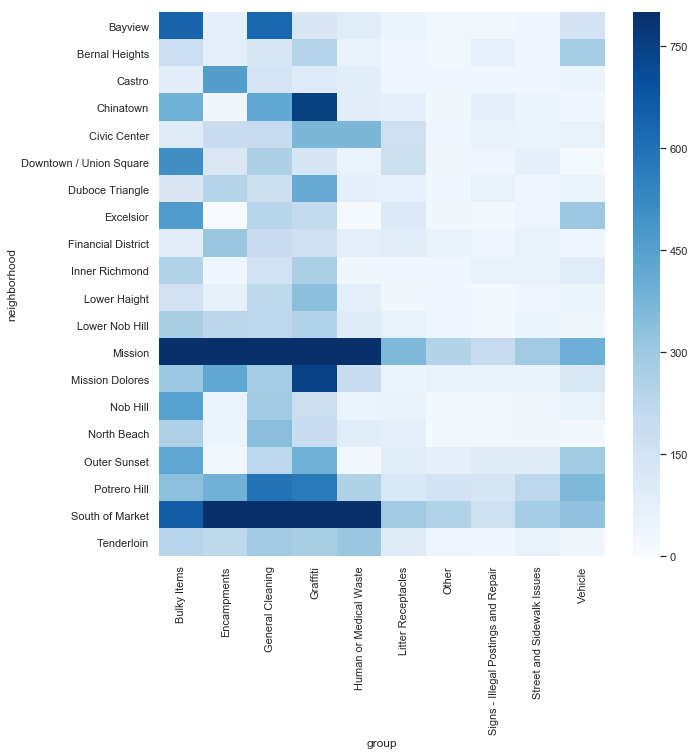

In [27]:
plt.figure(figsize=(10, 10))
sns.heatmap(neigh_type, vmin=0, vmax=800, cmap='Blues')
plt.show()

We can also see that different neighborhoods have different types of complaints.  For example, if there is a case in Excelsior, it is likely a Bulky Item pickup or a Vehicle related complaint.

## Cases by Month 
I am not looking into trends across years because I only looked at 2 years worth of data.  With more processing power or with a different sampling, it could be interesting to look at the change of types of cases reported across yearse.

In [28]:
month_type = df.groupby(['month', 'group'])['caseid'].count()
month_type = pd.DataFrame(month_type).reset_index()
#neigh_type = neigh_type.loc[neigh_type['group'].isin(common_groups) == True]
#month_type = month_type.pivot(index='month', columns='group', values='caseid')
month_type.fillna(0, inplace=True)
month_type.head()

,month,group,caseid
0,1,Bulky Items,1001
1,1,Damaged Property,77
2,1,Encampments,563
3,1,General Cleaning,1244
4,1,Graffiti,1706


In [29]:
month_counts = df.pivot_table(values='caseid', 
                              index='month', 
                              columns='group',
                              aggfunc='count')

month_counts['total'] = month_counts.sum(axis=1)
month_counts

group,Bulky Items,Damaged Property,Encampments,General Cleaning,Graffiti,Hazardous Materials,Human or Medical Waste,Litter Receptacles,Other,Rec and Park Requests,Sewer Issues,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Streetlights,Tree Maintenance,Vehicle,total
month,,,,,,,,,,,,,,,,,
1,1001,77,563,1244,1706,69,374,254,67,113,59,194,226,65,140,179,6331
2,869,73,470,981,1491,80,354,230,83,100,31,170,222,44,95,199,5492
3,851,68,651,996,1526,64,410,239,79,111,61,188,247,63,105,251,5910
4,905,89,739,1148,1439,86,394,238,139,117,57,157,298,40,116,421,6383
5,1060,88,880,1191,1262,110,464,271,180,136,48,197,255,41,134,675,6992
6,1096,89,908,1186,1318,93,446,307,144,145,44,259,261,30,122,566,7014
7,1033,95,1029,1207,1188,107,495,320,175,127,37,181,261,32,125,545,6957
8,1216,85,1105,1364,1183,110,605,350,227,124,32,204,246,45,135,628,7659
9,1042,71,997,1219,1073,132,616,331,250,117,63,240,278,58,107,589,7183


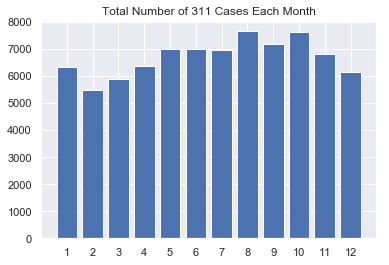

In [30]:
plt.bar(x=range(1,13), height='total', data=month_counts )
plt.xticks(range(1, 13))
plt.title('Total Number of 311 Cases Each Month')
plt.show()

In [31]:
month_counts_new = month_counts.iloc[:, :-1].div(month_counts['total'], axis=0) * 100

month_counts_new.reset_index(inplace=True)
month_counts_new

group,month,Bulky Items,Damaged Property,Encampments,General Cleaning,Graffiti,Hazardous Materials,Human or Medical Waste,Litter Receptacles,Other,Rec and Park Requests,Sewer Issues,Signs - Illegal Postings and Repair,Street and Sidewalk Issues,Streetlights,Tree Maintenance,Vehicle
0,1,15.811088,1.216238,8.892750,19.649344,26.946770,1.089875,5.907440,4.012004,1.058285,1.784868,0.931922,3.064287,3.569736,1.026694,2.211341,2.827357
1,2,15.823015,1.329206,8.557902,17.862345,27.148580,1.456664,6.445739,4.187910,1.511289,1.820830,0.564457,3.095412,4.042243,0.801165,1.729789,3.623452
2,3,14.399323,1.150592,11.015228,16.852792,25.820643,1.082910,6.937394,4.043993,1.336717,1.878173,1.032149,3.181049,4.179357,1.065990,1.776650,4.247039
3,4,14.178286,1.394329,11.577628,17.985273,22.544258,1.347329,6.172646,3.728654,2.177659,1.832994,0.892997,2.459658,4.668651,0.626665,1.817327,6.595645
4,5,15.160183,1.258581,12.585812,17.033753,18.049199,1.573227,6.636156,3.875858,2.574371,1.945080,0.686499,2.817506,3.647025,0.586384,1.916476,9.653890
5,6,15.625891,1.268891,12.945537,16.909039,18.790989,1.325920,6.358711,4.376960,2.053037,2.067294,0.627317,3.692615,3.721129,0.427716,1.739378,8.069575
6,7,14.848354,1.365531,14.790858,17.349432,17.076326,1.538019,7.115136,4.599684,2.515452,1.825499,0.531838,2.601696,3.751617,0.459968,1.796751,7.833836
7,8,15.876746,1.109805,14.427471,17.809113,15.445881,1.436219,7.899204,4.569787,2.963833,1.619010,0.417809,2.663533,3.211908,0.587544,1.762632,8.199504
8,9,14.506474,0.988445,13.879994,16.970625,14.938048,1.837672,8.575804,4.608102,3.480440,1.628846,0.877071,3.341222,3.870249,0.807462,1.489628,8.199916
9,10,14.490279,0.906463,13.452444,18.129270,12.821860,1.904887,10.260116,4.834472,4.125066,1.523910,0.643720,3.021545,3.126642,0.499212,1.576458,8.683657


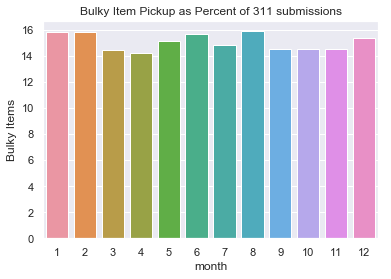

In [32]:
sns.barplot(x='month', 
            y='Bulky Items', 
            data=month_counts_new)
plt.title('Bulky Item Pickup as Percent of 311 submissions')
plt.show()

Overall, there are fewer cases in the dataset for February, but there is an increase in percent of Bulky Items.  Perhaps this is due to spring cleaning?

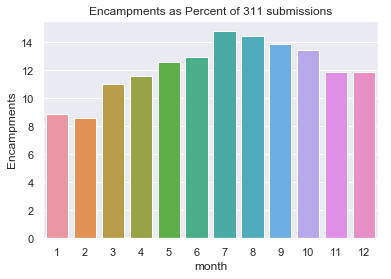

In [33]:
sns.barplot(x='month', 
            y='Encampments', 
            data=month_counts_new)
plt.title('Encampments as Percent of 311 submissions')
plt.show()

The higher proportion of encapments during the summer may be due to the better weather.

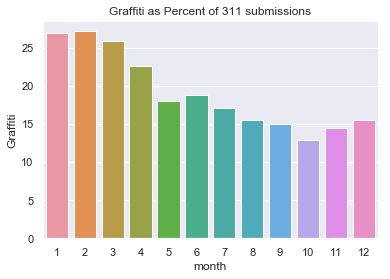

In [34]:
sns.barplot(x='month', 
            y='Graffiti', 
            data=month_counts_new)
plt.title('Graffiti as Percent of 311 submissions')
plt.show()

Maybe there is a campaign against graffiti in the Spring? Or it could be due to an increase of the percent of other complaints.  Since this is surprising to me, I will next look at the number of graffiti complaints.

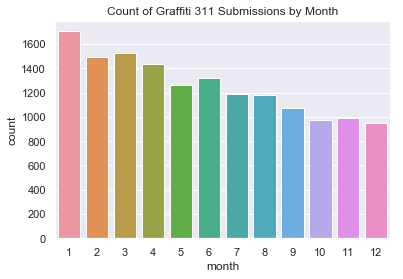

In [35]:
graffiti = pd.DataFrame({'month': range(1,13), 
                        'count': month_counts['Graffiti']})
sns.barplot(x='month', 
            y='count', 
            data=graffiti)
plt.title('Count of Graffiti 311 Submissions by Month')
plt.show()

Interesting, the number of graffiti cases also decreases from January to December. 

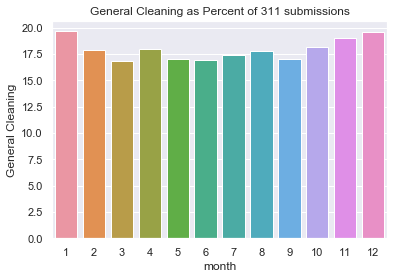

In [36]:
sns.barplot(x='month', 
            y='General Cleaning', 
            data=month_counts_new)
plt.title('General Cleaning as Percent of 311 submissions')
plt.show()

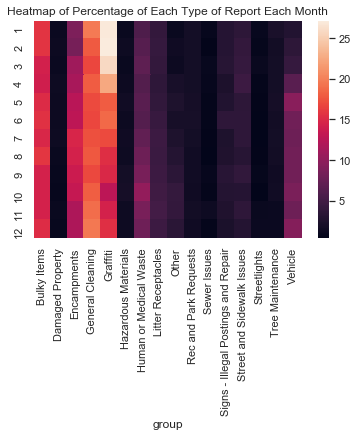

In [37]:
sns.heatmap(month_counts_new.iloc[:, 1:], yticklabels=range(1, 13))
plt.title('Heatmap of Percentage of Each Type of Report Each Month')
plt.show()

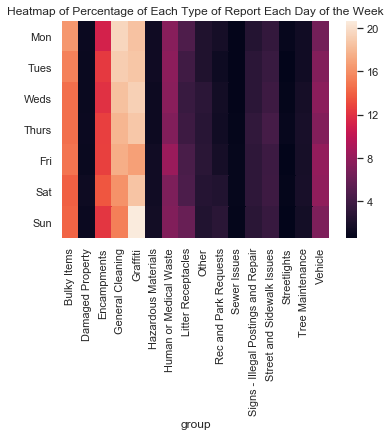

In [79]:
day_counts = df.pivot_table(values='caseid', 
                              index='day', 
                              columns='group',
                              aggfunc='count')

day_counts['total'] = day_counts.sum(axis=1)
day_counts_new = day_counts.iloc[:, :-1].div(day_counts['total'], axis=0) * 100

day_counts_new.reset_index(inplace=True)
#print(day_counts_new)

weekdays = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
sns.heatmap(day_counts_new.iloc[:, 1:], yticklabels=weekdays)
plt.yticks(rotation=0)
plt.title('Heatmap of Percentage of Each Type of Report Each Day of the Week')
plt.show()

# Modeling Using Categorical Variables

### Selected Features

In [82]:
# Store the features used for modeling
features = ['month', 'neighborhood', 'street', 'day']

### Training and test data sets

In [126]:
X = df[features].copy()
y = df['group'].copy()

le_month = LabelEncoder()
le_neigh = LabelEncoder()
le_street = LabelEncoder()
le_group = LabelEncoder()
le_day = LabelEncoder()

X['month'] = le_month.fit_transform(X['month'])
X['neighborhood'] = le_neigh.fit_transform(X['neighborhood'])
X['street'] = le_street.fit_transform(X['street'])
X['day'] = le_day.fit_transform(X['day'])

y = le_group.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

### Random Forest Classifier
Random forests handle categorical label encoded data reasonably well without one-hot encoding

In [86]:
parameters = {'max_features': range(1, 4),
              'n_estimators': [50, 100, 200, 300, 400, 500],
              'min_samples_leaf': [10, 50, 100, 200, 500]}

rfc = RandomForestClassifier()
cv = GridSearchCV(rfc, parameters, cv = 5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': range(1, 4), 'n_estimators': [50, 100, 200, 300, 400, 500], 'min_samples_leaf': [10, 50, 100, 200, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [87]:
cv.best_params_

{'max_features': 3, 'min_samples_leaf': 10, 'n_estimators': 300}

Training Set Score: 0.436
Test Set Score: 0.333


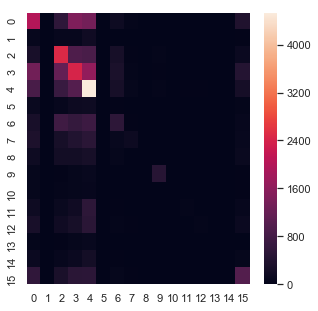

In [101]:
# Initiate a Random Forest Class
rfc = RandomForestClassifier(max_features=3,
                             min_samples_leaf=10,
                             n_estimators=300)

# Fit the Model
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

# Look at the score for the training under sampled data
y_train_pred = rfc.predict(X_train)
print('Training Set Score: {:.3f}'.format(rfc.score(X_train, y_train)))
print('Test Set Score: {:.3f}'.format(rfc.score(X_test, y_test)))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(confusion)
plt.show()

In [102]:
y_probs = rfc.predict_proba(X_test)

In [136]:
def plot_rocs(y_score, y_test):
  #n_classes = num_classes
  # Line width
    lw = 2

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

      # Compute macro-average ROC curve and ROC area

  # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr['micro'], tpr['micro'],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc['micro']),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr['macro'], tpr['macro'],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc['macro']),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple', 'green', 
                    'blue', 'pink', 'brown', 'red', 'teal', 'orange', 'lime',
                    'magenta', 'yellow', 'grey', 'olive', 'bright purple', 'cyan',
                    'lavender'])

    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of {0} (area = {1:0.2f})'.format(i, roc_auc[i]))


    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    # Put a legend to the right of the current axis
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i in range(0, num_classes):
        print('{}: {}'.format(i, le.inverse_transform([i])[0]))

In [137]:
enc1 = OneHotEncoder()
num_classes = 16
ohe_y = enc1.fit_transform(y_test.reshape(-1, 1))

plot_rocs(y_probs, ohe_y)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


TypeError: len() of unsized object

In [135]:
ohe_y.shape

(41128, 16)

In [113]:
y_probs.shape

(41128, 16)

In [41]:
print(le_group.inverse_transform([0, 2, 3, 4, 6, 9, 15]))

['Bulky Items' 'Encampments' 'General Cleaning' 'Graffiti'
 'Human or Medical Waste' 'Rec and Park Requests' 'Vehicle']


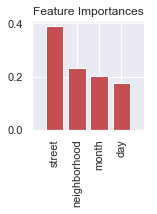

In [139]:
# Plot the feature importances
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(2,2))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), X.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

# Using One-Hot Encoding

In [140]:
X_ohe = df[features].copy()
y_le = df['group'].copy()

ohe = OneHotEncoder()
#ohe_neigh = LabelEncoder()
#ohe_street = LabelEncoder()
le_group = LabelEncoder()

X_ohe = ohe.fit_transform(X_ohe)
#X_ohe['neighborhood'] = le_neigh.fit_transform(X['neighborhood'])
#X_ohe['street'] = le_street.fit_transform(X['street'])
y = le_group.fit_transform(y_le)

X_ohe_train, X_ohe_test, y_train, y_test = train_test_split(X_ohe, 
                                                            y_le,
                                                            test_size=0.25,
                                                            random_state=42)

In [141]:
parameters = {'max_features': [10, 50, 200, 300, 500, 1000],
              'n_estimators': [50, 200, 400, 500],
              'min_samples_leaf': [10, 50, 100]}

cv = GridSearchCV(rfc, parameters, cv = 5)
cv.fit(X_ohe_train, y_train)

KeyboardInterrupt: 

In [ ]:
cv.best_params_

Training Set Score: 0.377
Test Set Score: 0.328


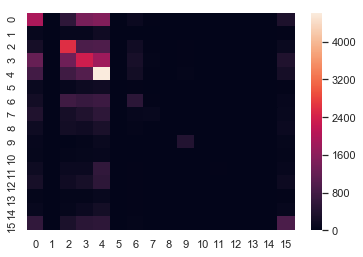

In [142]:
# Initiate a Random Forest Class
rfc_ohe = RandomForestClassifier(max_features=300,
                                 min_samples_leaf=10,
                                 n_estimators=400)

# Fit the Model
rfc_ohe.fit(X_ohe_train, y_train)
y_pred_ohe = rfc_ohe.predict(X_ohe_test)

# Look at the score for the training under sampled data
y_ohe_train_pred = rfc_ohe.predict(X_ohe_train)
print('Training Set Score: {:.3f}'.format(rfc_ohe.score(X_ohe_train, y_train)))
print('Test Set Score: {:.3f}'.format(rfc_ohe.score(X_ohe_test, y_test)))

confusion = confusion_matrix(y_test, y_pred_ohe)
sns.heatmap(confusion)
plt.show()

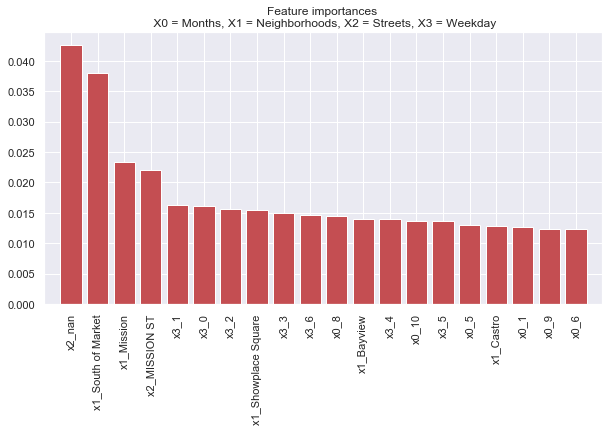

In [144]:
# Plot the feature importances
importances = rfc_ohe.feature_importances_
indices = np.argsort(importances)[::-1][0:20]

# Plot the feature importances of the forest
plt.figure(figsize=(10,5))
plt.title("Feature importances \n X0 = Months, X1 = Neighborhoods, X2 = Streets, X3 = Weekday")
plt.bar(range(len(indices)), importances[indices], color="r", align="center")
plt.xticks(range(len(indices)), ohe.get_feature_names()[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.show()

### For modeling with Keras, feature selection on one hot encoding

In [46]:
# For boolean Var[X] = p(1-p)
# Remove all features that are either 1 or 0 in more than 99.5% of
# the samples
sel = VarianceThreshold(threshold=(.9995 * (1-.9995)))
X_sel_train = sel.fit_transform(X_ohe_train)
X_sel_test = sel.transform(X_ohe_test)

In [47]:
X_ohe_train.shape

(60390, 1935)

In [48]:
X_sel_train.shape

(60390, 466)

In [49]:
sel.get_support

<bound method SelectorMixin.get_support of VarianceThreshold(threshold=0.000499749999999945)>

In [50]:
# Features selected by the variance threshold
features_sel = ohe.get_feature_names()[sel.get_support(indices=True)]

In [51]:
features_sel

array(['x0_1', 'x0_2', 'x0_3', 'x0_4', 'x0_5', 'x0_6', 'x0_7', 'x0_8',
       'x0_9', 'x0_10', 'x0_11', 'x0_12', 'x1_Alamo Square',
       'x1_Anza Vista', 'x1_Apparel City', 'x1_Aquatic Park / Ft. Mason',
       'x1_Ashbury Heights', 'x1_Bayview', 'x1_Bernal Heights',
       'x1_Bret Harte', 'x1_Buena Vista', 'x1_Castro',
       'x1_Cathedral Hill', 'x1_Cayuga', 'x1_Central Waterfront',
       'x1_Chinatown', 'x1_Civic Center', 'x1_Clarendon Heights',
       'x1_Cole Valley', 'x1_Corona Heights', 'x1_Cow Hollow',
       'x1_Crocker Amazon', 'x1_Diamond Heights', 'x1_Dogpatch',
       'x1_Dolores Heights', 'x1_Downtown / Union Square',
       'x1_Duboce Triangle', 'x1_Eureka Valley', 'x1_Excelsior',
       'x1_Fairmount', 'x1_Financial District', "x1_Fisherman's Wharf",
       'x1_Forest Hill', 'x1_Glen Park', 'x1_Golden Gate Heights',
       'x1_Golden Gate Park', 'x1_Haight Ashbury', 'x1_Hayes Valley',
       'x1_Holly Park', 'x1_Hunters Point', 'x1_India Basin',
       'x1_Ingleside

In [52]:
sel_k = SelectKBest(chi2, k=200)
X_sel_k = sel_k.fit_transform(X_sel_train, y_train)
X_sel_k_test = sel_k.transform(X_sel_test)

In [53]:
features_sel_k = features_sel[sel_k.get_support(indices=True)]
print(features_sel_k)

['x0_1' 'x0_2' 'x0_3' 'x0_4' 'x0_8' 'x0_9' 'x0_10' 'x0_11' 'x0_12'
 'x1_Alamo Square' 'x1_Apparel City' 'x1_Bayview' 'x1_Bernal Heights'
 'x1_Buena Vista' 'x1_Castro' 'x1_Cathedral Hill' 'x1_Cayuga'
 'x1_Central Waterfront' 'x1_Chinatown' 'x1_Civic Center' 'x1_Cole Valley'
 'x1_Corona Heights' 'x1_Dogpatch' 'x1_Downtown / Union Square'
 'x1_Duboce Triangle' 'x1_Excelsior' 'x1_Financial District'
 "x1_Fisherman's Wharf" 'x1_Glen Park' 'x1_Golden Gate Heights'
 'x1_Golden Gate Park' 'x1_Haight Ashbury' 'x1_Holly Park'
 'x1_Hunters Point' 'x1_India Basin' 'x1_Ingleside'
 'x1_Ingleside Terraces' 'x1_Inner Richmond' 'x1_Inner Sunset'
 'x1_Lake Street' 'x1_Lakeshore' 'x1_Lower Haight' 'x1_Lower Nob Hill'
 'x1_Marina' 'x1_McLaren Park' 'x1_Merced Heights' 'x1_Miraloma Park'
 'x1_Mission' 'x1_Mission Bay' 'x1_Mission Dolores' 'x1_Mission Terrace'
 'x1_Nob Hill' 'x1_Noe Valley' 'x1_North Beach' 'x1_Oceanview'
 'x1_Outer Richmond' 'x1_Outer Sunset' 'x1_Panhandle' 'x1_Parkside'
 'x1_Peralta Heigh

Training Set Score: 0.314
Test Set Score: 0.293


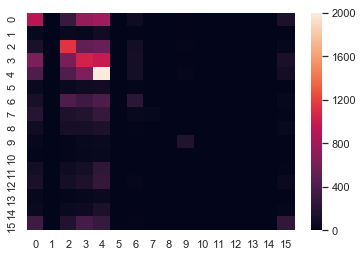

In [55]:
# Initiate a Random Forest Class
rfc_sel = RandomForestClassifier(max_features=50,
                                 min_samples_leaf=20,
                                 n_estimators=400)

# Fit the Model
rfc_sel.fit(X_sel_k, y_train)
y_pred_sel = rfc_sel.predict(X_sel_k_test)

# Look at the score for the training under sampled data
y_sel_train_pred = rfc_sel.predict(X_sel_k)
print('Training Set Score: {:.3f}'.format(rfc_sel.score(X_sel_k, y_train)))
print('Test Set Score: {:.3f}'.format(rfc_sel.score(X_sel_k_test, y_test)))

confusion = confusion_matrix(y_test, y_pred_sel)
sns.heatmap(confusion, vmin=0, vmax=2000)
plt.show()

We lose a little accuracy with the random forest classifier when we limit it to 200 features, but this may be worthwhile when we move to creating a model combining these features and the images. The model with the images will already consume a large amount of memory, and I will need to optimize that where I can.

In [56]:
X_sel_k_test.shape

(20130, 200)